In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import os
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
path=r"C:\Users\andyk\OneDrive\Documents\Kaggle\Untitled Folder\Data"
test=pd.read_csv(os.path.join(path,"test.csv"))
train=pd.read_csv(os.path.join(path, "train.csv"))

pd.options.display.max_rows = 999

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.drop("PassengerId", axis=1).describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024675B5CCF8>,
      dtype=object)

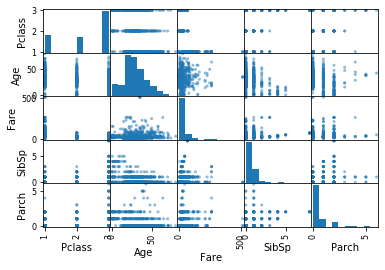

In [5]:
pd.plotting.scatter_matrix(train[["Pclass", "Age", "Fare", "SibSp", "Parch"]])

In [6]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


##### simply based off correlation, we expect Pclass and Fare to be the best predictors of survival, which intuitively makes sense
##### However, Pclass and Fare also have high correlation, potential multicollinearity

In [7]:
#get number of missing values in each column
print(train.shape[0])
print(train.isna().sum())
print(train.isna().sum()/train.shape[0])

891
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


##### ~20% of age is missing, ~77% of cabin is missing, a couple of embarked is missing. We can try a couple of imputation methods for embarked, as well as for age. Cabin presents more difficulty

### Cabin:

In [8]:
#print(test["Cabin"].unique(), len(test["Cabin"].unique()))
print(train["Cabin"].isna().sum())
print(train["Cabin"].count())

687
204


##### way more nan for cabin than actual values, probably isn't a useful column to include/not worth imputing at least initially

##### lets make a cabin level variable based on the first letter of the cabin, and a port/starboard based on the number (even is starboard, odd is port). This is based on https://www.encyclopedia-titanica.org/titanic-deckplans/a-deck.html

In [9]:
train.sort_values(by="Name")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
845,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.5500,NaN,S
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.2500,NaN,S
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.2500,NaN,S
308,309,0,2,"Abelson, Mr. Samuel",male,30.00,1,0,P/PP 3381,24.0000,NaN,C
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.00,1,0,P/PP 3381,24.0000,NaN,C
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.00,0,0,C 7076,7.2500,NaN,S
401,402,0,3,"Adams, Mr. John",male,26.00,0,0,341826,8.0500,NaN,S
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.4750,NaN,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.00,0,1,392091,9.3500,NaN,S
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.00,0,0,2699,18.7875,NaN,C


### Sex:

In [10]:
#male female distribution
male=len(train[train["Sex"]=="male"])
female=len(train[train["Sex"]=="female"])
neither=len(train[(train["Sex"]!="male")&(train["Sex"]!="female")])
print(female/male)
print(neither)

0.5441941074523396
0


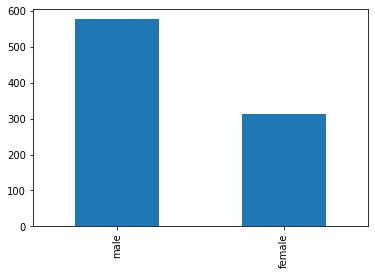

In [11]:
pd.value_counts(train["Sex"]).plot.bar()

### Age:

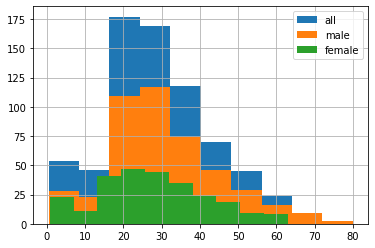

In [12]:
#age distribution
train["Age"].hist(label="all")
#male age dist
train[train["Sex"]=="male"]["Age"].hist(label="male")
#female age dist
train[train["Sex"]=="female"]["Age"].hist(label="female")
plt.legend()

In [13]:
#age imputation

#mean
train["Age_mean"]=train["Age"].fillna(train["Age"].mean())
test["Age_mean"]=test["Age"].fillna(test["Age"].mean())

#median
train["Age_med"]=train["Age"].fillna(train["Age"].median())
test["Age_med"]=test["Age"].fillna(test["Age"].median())

train["impute_diff"]=train["Age_mean"]-train["Age_med"]

train["impute_diff"].describe()

count    891.000000
mean       0.337535
std        0.678305
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.699118
Name: impute_diff, dtype: float64

### Fare:

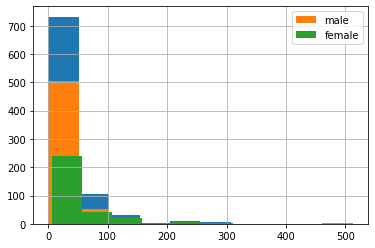

In [14]:
train["Fare"].hist()
train[train["Sex"]=="male"]["Fare"].hist(label="male")
train[train["Sex"]=="female"]["Fare"].hist(label="female")
plt.legend()

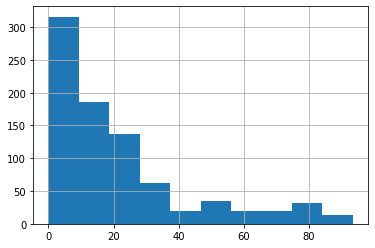

In [15]:
train[train["Fare"]<100]["Fare"].hist()

#### Might want to transform some of the variables to get normality, at least the fare variable (do this later)

In [130]:
#log transform fare based on shape of dist
#train["log_fare"]=np.log(train["Fare"]).fillna(0)
#train["bc_fare"]=stats.boxcox(train["Fare"])
train["Fare"].value_counts()
#first, there's a fare with value 0
#ie logfare will have negative inf
train.head()

C:\Users\andyk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


ValueError: Data must be positive.

##### should consider removing the first of these values, as it has close to no information. We could consider imputing the second value based on the other values (knn)

In [17]:
#train["trans_fare"], fare_lambda=stats.boxcox(train["Fare"])
#train["trans_fare"].hist()
#train["log_fare"].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

### Embarked:

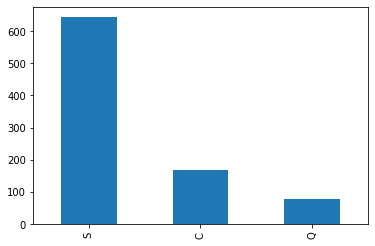

In [18]:
pd.value_counts(train["Embarked"]).plot.bar()

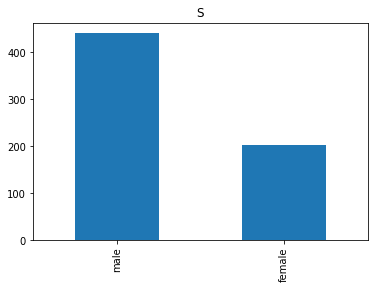

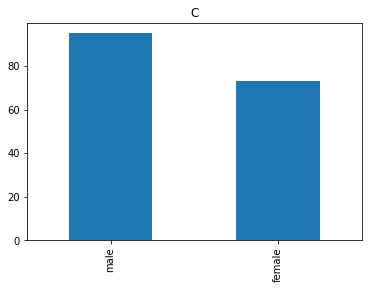

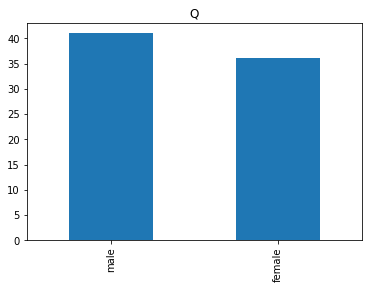

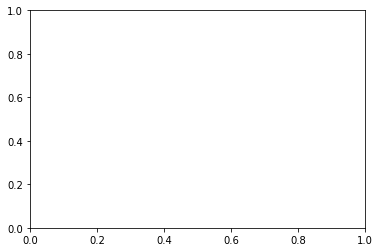

In [37]:
#creating an extra plot, probably for null values. Could fix this later but minor problem
for e in list(train["Embarked"].unique()):
    try:
        plt.figure()
        pd.value_counts(train[train["Embarked"]==e]["Sex"]).plot.bar(title=e)
        plt.show()
    except:
        continue

##### Q has the closest distribution to overall, but good to know its not homogenous between departure places
##### intuitively this column won't be a good predictor besides as a proxy for wealth, family dynamics, or gender breakdown

In [20]:
#fill in the missing embarked values with mode
train["Embarked_mode"]=train["Embarked"].fillna(train["Embarked"].mode())

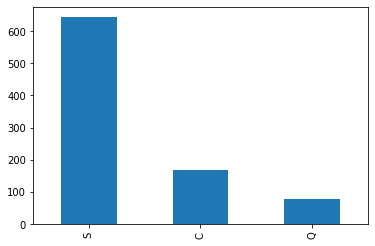

In [21]:
pd.value_counts(train["Embarked_mode"]).plot.bar()

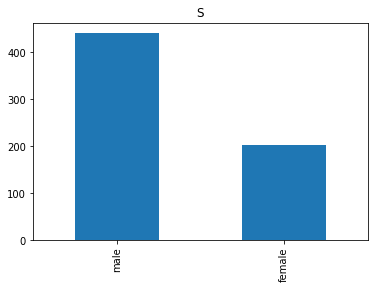

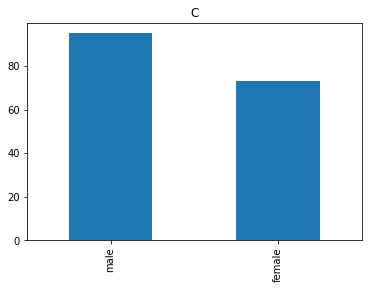

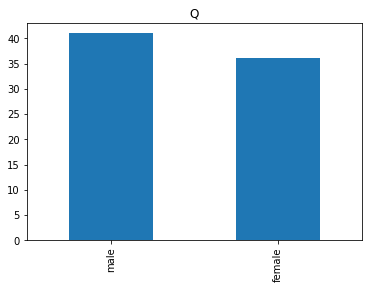

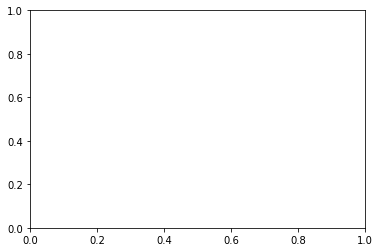

In [38]:
#same as above
for e in list(train["Embarked_mode"].unique()):
    try:
        plt.figure()
        pd.value_counts(train[train["Embarked_mode"]==e]["Sex"]).plot.bar(title=e)
        plt.show()
    except:
        continue

### PClass:

In [ ]:
pd.value_counts(train["Pclass"]).plot.bar()

In [131]:
train.groupby("Pclass")[["Age", "Fare", "SibSp", "Parch", "Survived"]].agg(["mean", "std", "median", "count"])

Age                               Fare                      \
             mean        std median count       mean        std   median   
Pclass                                                                     
1       38.233441  14.802856   37.0   186  84.154687  78.380373  60.2875   
2       29.877630  14.001077   29.0   173  20.662183  13.417399  14.2500   
3       25.140620  12.495398   24.0   355  13.675550  11.778142   8.0500   

                 SibSp                            Parch                   \
       count      mean       std median count      mean       std median   
Pclass                                                                     
1        216  0.416667  0.611898      0   216  0.356481  0.693997      0   
2        184  0.402174  0.601633      0   184  0.380435  0.690963      0   
3        491  0.615071  1.374883      0   491  0.393075  0.888861      0   

              Survived                         
       count      mean       std median count  
Pclass                                         
1        216  0.629630  0.484026      1   216  
2        184  0.472826  0.500623      0   184  
3        491  0.242363  0.428949      0   491

### SibSp:

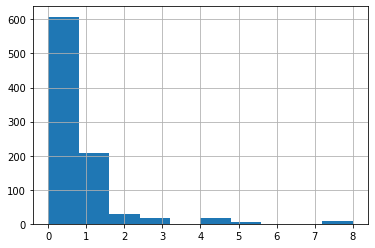

In [119]:
train["SibSp"].hist()

### Parch:

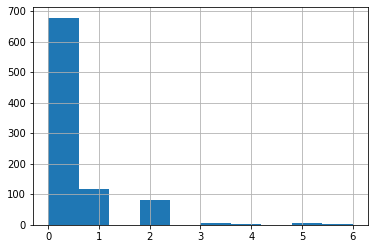

In [120]:
train["Parch"].hist()

## Logistic Regression

##### Easy to add columns only

In [136]:
#make levels for embarked, sex
train_dummies=pd.get_dummies(train, columns=["Embarked_mode", "Sex"], drop_first=True, prefix="levels")

In [137]:
train_dummies.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_mean,Age_med,impute_diff,log_fare,levels_Q,levels_S,levels_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,22.0,0.0,1.981001,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,38.0,38.0,0.0,4.266662,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,26.0,0.0,2.070022,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,35.0,35.0,0.0,3.972177,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,35.0,35.0,0.0,2.085672,0,1,1


In [142]:
good_cols=["Pclass", "levels_Q", "levels_S", "levels_male", "Parch", "Age_mean", "Fare"]

#train_dummies=train_dummies.dropna()

X_train=train_dummies[good_cols]
Y_train=train_dummies["Survived"]

X_test=test_dummies[good_cols]

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

#NOTE: This has an L2 penalty, so like a ridge logistic regression
#setting a really high C value is a workaround to this, to make it unpenalized
#C is the inverse of the regularization strength, so not exact but pretty good
logreg=LogisticRegression(C=50000)
reg_train=logreg.fit(x_train, y_train)

C:\Users\andyk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [143]:
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.510886
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.235     
Dependent Variable: Survived         AIC:              650.5634  
Date:               2019-12-28 15:56 BIC:              681.6053  
No. Observations:   623              Log-Likelihood:   -318.28   
Df Model:           6                LL-Null:          -416.19   
Df Residuals:       616              LLR p-value:      1.4695e-39
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass       -0.0179    0.1006   -0.1777  0.8589  -0.2150   0.1792
levels_Q      0.4001    0.4141    0.9663  0.3339  -0.4114   1.

#### We see from the p values that sex, fare, and age are the most important predictors, though sex and fare are the only significant variables. levels_male has a negative coefficient, suggesting that women were more likely to survive than men (men had a -2.2 smaller log odds of survival when compared to women). Fare has a positive coefficient, suggesting that those with a higher fare were more likely to survive than those with a lower fare (a unit increase in fare led to a 0.01 increase in log odds of survival). This suggests that wealthy women were the most likely to survive.

In [144]:
#test_x=test_dummies[good_cols]
pred_y = logreg.predict(x_test)

In [145]:
def corr_pred_ratio(c_matrix):
    return (c_matrix[0][0]+c_matrix[1][1])/np.sum(c_matrix)

In [146]:
cm = confusion_matrix(y_test.tolist(), pred_y.tolist())
print(cm)

[[139  29]
 [ 27  73]]


In [147]:
correct_prediction_ratio=corr_pred_ratio(cm)
print(correct_prediction_ratio)

0.7910447761194029


#### Ideally we do the confusion matrix on the actual survivor list, but this is ok for proof of concept. We are basically ignoring the list of people we are supposed to predict from the kaggle comp but thats fine

### Random Forest

In [150]:
rf=RandomForestClassifier(n_estimators = 5000, random_state = 42)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [151]:
pred_rf=rf.predict(x_test)
confusion_matrix_rf=confusion_matrix(y_test, pred_rf)
pred_ratio=corr_pred_ratio(confusion_matrix_rf)
print(pred_ratio)

0.8208955223880597


#### Note that this ratio is higher than the logistic regression model, so the random forest is more accurate than the logistic regression

In [152]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       168
           1       0.79      0.71      0.75       100

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268



In [153]:
# Get numerical feature importances
feature_list=list(X_train.columns)
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
print(feature_importances)

[('Age_mean', 0.28), ('Fare', 0.28), ('levels_male', 0.26), ('Pclass', 0.09), ('Parch', 0.04), ('levels_S', 0.03), ('levels_Q', 0.01)]


[0.28 0.56 0.82 0.91 0.95 0.98 0.99]


Text(0.5, 1.0, 'Cumulative Importances')

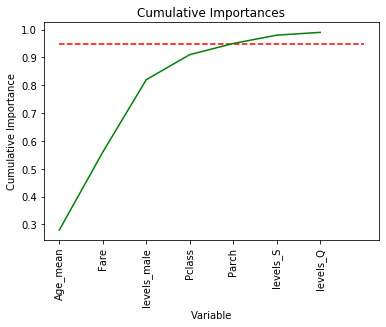

In [154]:
# list of x locations for plotting
x_values = list(range(len(importances)))
#list of features sorted from most to least importatnt
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
print(cumulative_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')



#### age, fare, and sex are the most important variables, with class and number of family members as secondary variables. This suggests that the youngest people, women, and those with the most expensive tickets were most likely to survive. There was likely preference due to wealth class

### XGBoost

In [ ]:
dtrain=xgb.DMatrix(em_train_dummies)
dtest=xgb.DMatrix(em_test_dummies)